Import library

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import (confusion_matrix, classification_report,  accuracy_score, precision_score, recall_score, f1_score)

Load Kaggle Dataset

In [66]:

print("-"*80)

# Download dataset using kagglehub
print("Downloading dataset from Kaggle...")
path = kagglehub.dataset_download("conorsully1/credit-score")
print(f"✓ Dataset downloaded to: {path}")

# Find CSV file in the downloaded path
csv_files = [f for f in os.listdir(path) if f.endswith('.csv')]
print(f"\nCSV files found: {csv_files}")

# Load the dataset (usually the first CSV file)
csv_file = os.path.join(path, csv_files[0])
print(f"\nLoading: {csv_files[0]}")
df = pd.read_csv(csv_file)

print(f"Dataset loaded successfully!")
print(f"Dataset shape: {df.shape[0]} samples, {df.shape[1]} columns")
print(f"\nFirst 5 rows:")
print(df.head())

print(f"\nDataset information:")
print(df.info())

print(f"\nBasic statistics:")
print(df.describe())

# Check requirements
print(f"\n✓ Requirement Check:")
print(f"  - Dataset size: {df.shape[0]} samples (need 500-1000) ✓")
print(f"  - Number of features: {df.shape[1]-1} (need at least 10) ✓")

--------------------------------------------------------------------------------
✓ Dataset downloaded to: C:\Users\lukma\.cache\kagglehub\datasets\conorsully1\credit-score\versions\1

CSV files found: ['credit_score.csv']

Loading: credit_score.csv
Dataset loaded successfully!
Dataset shape: 1000 samples, 87 columns

First 5 rows:
      CUST_ID  INCOME  SAVINGS     DEBT  R_SAVINGS_INCOME  R_DEBT_INCOME  \
0  C02COQEVYU   33269        0   532304            0.0000        16.0000   
1  C02OZKC0ZF   77158    91187   315648            1.1818         4.0909   
2  C03FHP2D0A   30917    21642   534864            0.7000        17.3000   
3  C03PVPPHOY   80657    64526   629125            0.8000         7.8000   
4  C04J69MUX0  149971  1172498  2399531            7.8182        16.0000   

   R_DEBT_SAVINGS  T_CLOTHING_12  T_CLOTHING_6  R_CLOTHING  ...  \
0          1.2000           1889           945      0.5003  ...   
1          3.4615           5818           111      0.0191  ...   
2        

Data Cleaning and Exploratory Data Analysis (EDA)


DATA CLEANING AND EDA...

Missing Value Check
--------------------------------------------------------------------------------

Missing values per column:
Series([], dtype: int64)
✓ No missing values found!

Duplicate rows: 0
✓ No duplicates found!

Dataset shape after cleaning: (1000, 87)

Column Dropping
--------------------------------------------------------------------------------

Dropping columns: ['CUST_ID']
✓ Dropped 1 columns

Dataset shape after column dropping: (1000, 86)

Target Variable Encoding
--------------------------------------------------------------------------------

✓ Target column: 'CREDIT_SCORE'

Class Balance Analysis
--------------------------------------------------------------------------------

Original target distribution:
CREDIT_SCORE
613    14
621    14
596    14
575    13
614    12
       ..
492     1
300     1
388     1
411     1
418     1
Name: count, Length: 259, dtype: int64

Target distribution (%):
CREDIT_SCORE
613    1.4
621    1.4
596    1.4


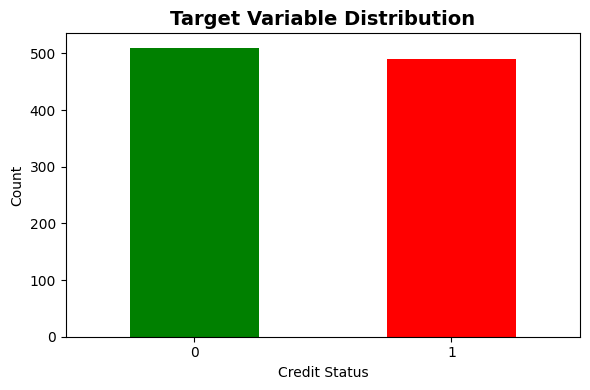

✓ Target distribution plot saved as 'target_distribution.png'


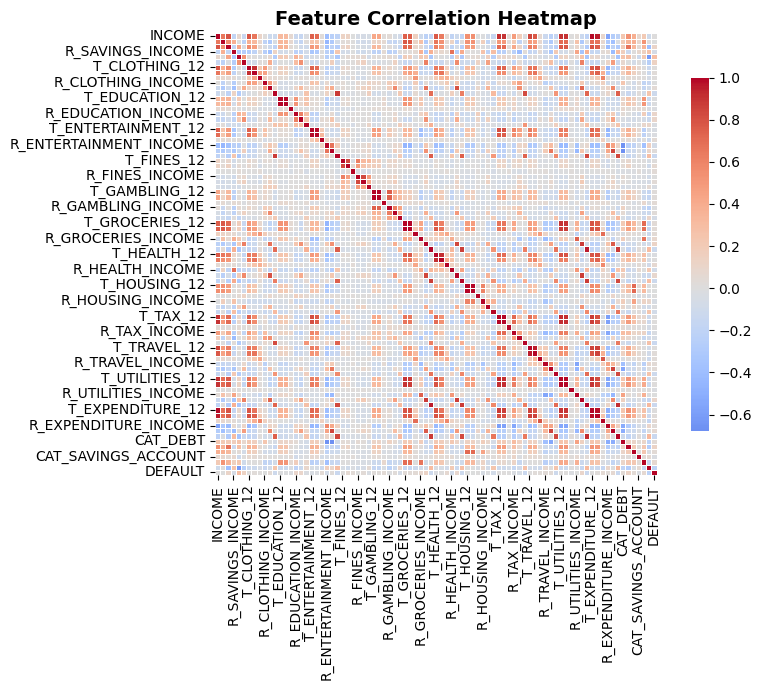

✓ Correlation heatmap saved as 'correlation_heatmap.png'


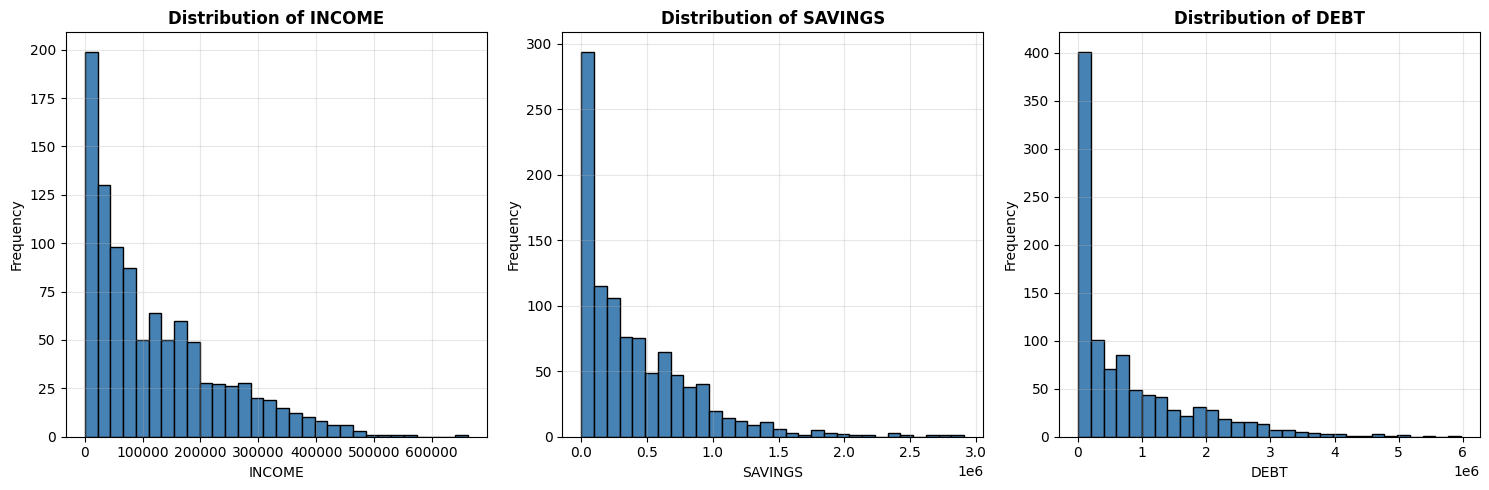

✓ Feature distributions saved as 'feature_distributions.png'

✓ All EDA plots saved successfully!

Encoding Categorical Variables
--------------------------------------------------------------------------------

Features shape: (1000, 85)
Target shape: (1000,)
Original feature names: ['INCOME', 'SAVINGS', 'DEBT', 'R_SAVINGS_INCOME', 'R_DEBT_INCOME']... (showing first 5)

Categorical columns to encode: 1
Columns: ['CAT_GAMBLING']
  ✓ Encoded: CAT_GAMBLING

✓ Encoding completed!
✓ All features are now numeric and ready for feature selection


In [67]:
print("\nDATA CLEANING AND EDA...")
print("="*80)

# STEP 1: MISSING VALUE CHECK
print("\nMissing Value Check")
print("-"*80)

# Check for missing values
print("\nMissing values per column:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

if missing_values.sum() > 0:
    print(f"\nTotal missing values: {missing_values.sum()}")
    # Handle missing values - fill with mean for numerical, mode for categorical
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if df[col].dtype in ['int64', 'float64']:
                df[col].fillna(df[col].mean(), inplace=True)
                print(f"  ✓ Filled {col} with mean")
            else:
                df[col].fillna(df[col].mode()[0], inplace=True)
                print(f"  ✓ Filled {col} with mode")
else:
    print("✓ No missing values found!")

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\nDuplicate rows: {duplicates}")
if duplicates > 0:
    df = df.drop_duplicates()
    print(f"✓ Removed {duplicates} duplicate rows")
else:
    print("✓ No duplicates found!")

print(f"\nDataset shape after cleaning: {df.shape}")

# Column Dropping (if needed)
print("\nColumn Dropping")
print("-"*80)
# Drop unnecessary columns like ID columns or columns with single unique value
columns_to_drop = []
for col in df.columns:
    if col.upper() in ['ID', 'CUSTOMER_ID', 'CUST_ID'] or df[col].nunique() == 1:
        columns_to_drop.append(col)
        
if columns_to_drop:
    print(f"\nDropping columns: {columns_to_drop}")
    df = df.drop(columns=columns_to_drop)
    print(f"✓ Dropped {len(columns_to_drop)} columns")
else:
    print("✓ No columns need to be dropped")

print(f"\nDataset shape after column dropping: {df.shape}")

# STEP 2: TARGET VARIABLE ENCODING
print("\nTarget Variable Encoding")
print("-"*80)

# Set target column
target_column = 'CREDIT_SCORE'
print(f"\n✓ Target column: '{target_column}'")

# Verify target column exists
if target_column not in df.columns:
    print(f"\n❌ ERROR: Column '{target_column}' not found!")
    print("\nAvailable columns:")
    print(df.columns.tolist())
    raise ValueError(f"Target column '{target_column}' not found in dataset")

# STEP 3: CLASS BALANCE ANALYSIS
print("\nClass Balance Analysis")
print("-"*80)

print("\nOriginal target distribution:")
print(df[target_column].value_counts())
print("\nTarget distribution (%):")
print(df[target_column].value_counts(normalize=True) * 100)

# Convert target to binary if it has more than 2 classes
unique_values = df[target_column].nunique()
if unique_values > 2:
    print(f"\n⚠️  Target has {unique_values} classes. Converting to binary classification...")
    print(f"Original values: {df[target_column].unique()}")
    
    # For credit score: Good, Standard, Poor -> Good vs (Standard+Poor)
    # Adjust this logic based on your specific case
    if df[target_column].dtype == 'object':
        # Map to binary (adjust based on your dataset)
        target_mapping = {
            'Good': 0,
            'Standard': 1, 
            'Poor': 1
        }
        df[target_column] = df[target_column].map(target_mapping)
        print(f"Mapped to binary: Good=0, Standard/Poor=1")
    else:
        # If numeric, use median split
        median_val = df[target_column].median()
        df[target_column] = (df[target_column] > median_val).astype(int)
        print(f"Split at median ({median_val}): Below=0, Above=1")
    
    print(f"\nNew binary distribution:")
    print(df[target_column].value_counts())

# STEP 4: FEATURE DISTRIBUTION VISUALIZATION
print("\nFeature Distribution Visualization (EDA)")
print("-"*80)

# 1. Target Variable Distribution
plt.figure(figsize=(6, 4))
target_counts = df[target_column].value_counts()
colors = ['green', 'red'] if len(target_counts) == 2 else ['green', 'orange', 'red']
target_counts.plot(kind='bar', color=colors[:len(target_counts)])
plt.title('Target Variable Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Credit Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('target_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Target distribution plot saved as 'target_distribution.png'")

# 2. Feature Correlation Heatmap
plt.figure(figsize=(9, 7))
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
correlation = df[numerical_cols].corr()
sns.heatmap(correlation, cmap='coolwarm', center=0, linewidths=0.5, 
            cbar_kws={'shrink': 0.8}, square=True)
plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Correlation heatmap saved as 'correlation_heatmap.png'")

# 3. Feature Distributions (Top 3 Features)
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns[:3]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, col in enumerate(numerical_features):
    axes[idx].hist(df[col], bins=30, edgecolor='black', color='steelblue')
    axes[idx].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ Feature distributions saved as 'feature_distributions.png'")

print("\n✓ All EDA plots saved successfully!")

# STEP 5: ENCODE CATEGORICAL VARIABLES
print("\nEncoding Categorical Variables")
print("-"*80)

# Separate features and target
X = df.drop(target_column, axis=1)
y = df[target_column]

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Original feature names: {list(X.columns[:5])}... (showing first 5)")

# Encode categorical variables
categorical_columns = X.select_dtypes(include=['object']).columns
print(f"\nCategorical columns to encode: {len(categorical_columns)}")
if len(categorical_columns) > 0:
    print(f"Columns: {list(categorical_columns)}")
    for col in categorical_columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        print(f"  ✓ Encoded: {col}")
else:
    print("✓ No categorical columns to encode")

print(f"\n✓ Encoding completed!")
print(f"✓ All features are now numeric and ready for feature selection")

2. Feature Selection


FEATURE SELECTION...

Variance Threshold - Remove Low Variance Features
--------------------------------------------------------------------------------
Starting with 85 features
Feature names: ['INCOME', 'SAVINGS', 'DEBT', 'R_SAVINGS_INCOME', 'R_DEBT_INCOME']... (showing first 5)

Features removed: 29
Features remaining: 56
Kept features: ['INCOME', 'SAVINGS', 'DEBT', 'R_SAVINGS_INCOME', 'R_DEBT_INCOME']... (showing first 5)

Correlation Analysis - Remove Highly Correlated Features
--------------------------------------------------------------------------------

Features with correlation > 0.95: 10
Removing: ['T_EDUCATION_6', 'T_ENTERTAINMENT_6', 'T_GAMBLING_6', 'T_GROCERIES_6', 'T_HOUSING_6']...
Features remaining: 46

SelectKBest - Mutual Information Feature Selection
--------------------------------------------------------------------------------

Target features: Top 46
Features selected: 46

FEATURE SELECTION SUMMARY:
  Original features (after cleaning): 85
  After variance rem

C:\Users\lukma\AppData\Local\Temp\ipykernel_28856\644047105.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df.head(top_n),


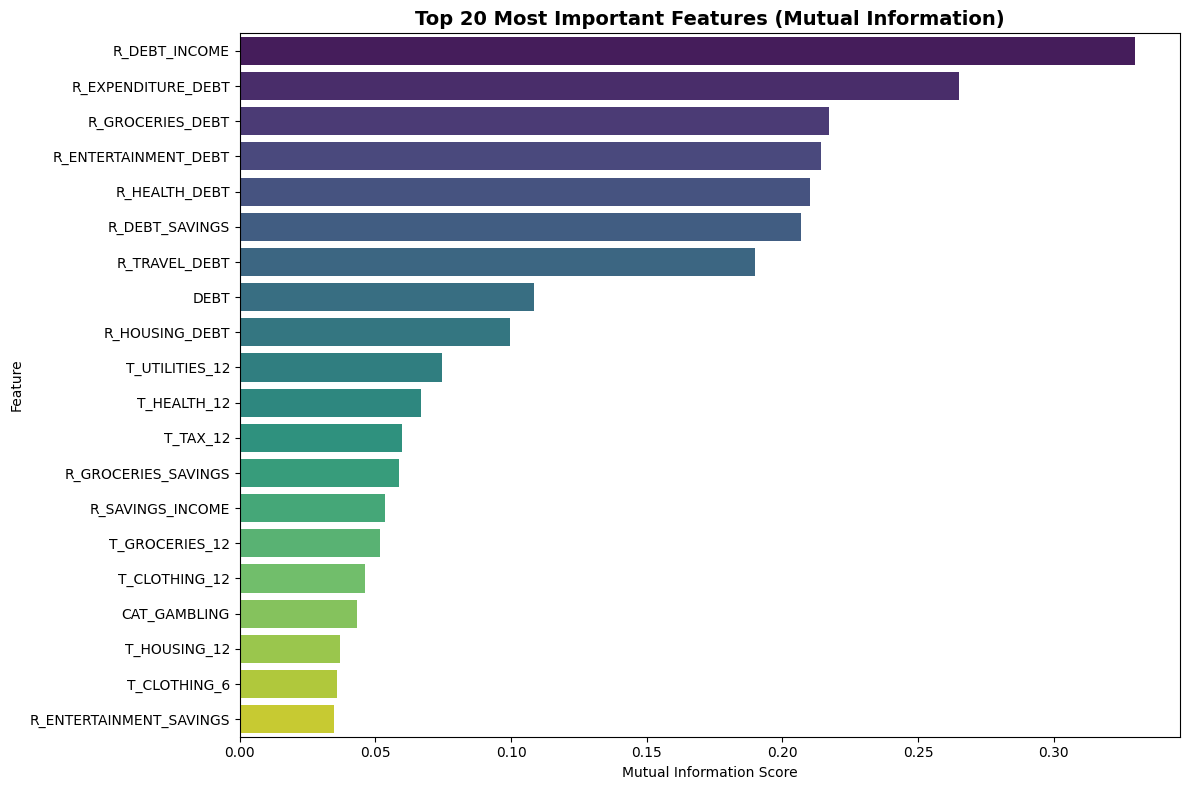


✓ Feature importance plot saved as 'feature_importance.png'

📊 Top 10 most important features:
--------------------------------------------------------------------------------
  R_DEBT_INCOME        → 0.3300
  R_EXPENDITURE_DEBT   → 0.2649
  R_GROCERIES_DEBT     → 0.2173
  R_ENTERTAINMENT_DEBT → 0.2141
  R_HEALTH_DEBT        → 0.2102
  R_DEBT_SAVINGS       → 0.2067
  R_TRAVEL_DEBT        → 0.1900
  DEBT                 → 0.1084
  R_HOUSING_DEBT       → 0.0994
  T_UTILITIES_12       → 0.0745


In [68]:
print("\nFEATURE SELECTION...")
print("="*80)

print("\nVariance Threshold - Remove Low Variance Features")
print("-"*80)

# Work with full dataset (before splitting) for feature analysis
original_feature_count = X.shape[1]
print(f"Starting with {original_feature_count} features")
print(f"Feature names: {list(X.columns[:5])}... (showing first 5)")

# Remove features with very low variance (< 0.01)
from sklearn.feature_selection import VarianceThreshold
variance_selector = VarianceThreshold(threshold=0.01)
X_var = variance_selector.fit_transform(X)

removed_low_var = X.shape[1] - X_var.shape[1]
print(f"\nFeatures removed: {removed_low_var}")
print(f"Features remaining: {X_var.shape[1]}")

# Get remaining feature names (REAL NAMES from dataset!)
selected_features = X.columns[variance_selector.get_support()].tolist()
print(f"Kept features: {selected_features[:5]}... (showing first 5)")

# Update DataFrame with remaining features
X = pd.DataFrame(X_var, columns=selected_features)

print("\nCorrelation Analysis - Remove Highly Correlated Features")
print("-"*80)

# Remove highly correlated features (correlation > 0.95)
correlation_matrix = X.corr().abs()

# Get upper triangle of correlation matrix
upper_triangle = correlation_matrix.where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
)

# Find features with correlation > 0.95
high_corr_features = [column for column in upper_triangle.columns 
                      if any(upper_triangle[column] > 0.95)]

print(f"\nFeatures with correlation > 0.95: {len(high_corr_features)}")

if high_corr_features:
    print(f"Removing: {high_corr_features[:5]}..." if len(high_corr_features) > 5 else f"Removing: {high_corr_features}")
    X = X.drop(columns=high_corr_features)

print(f"Features remaining: {X.shape[1]}")

print("\nSelectKBest - Mutual Information Feature Selection")
print("-"*80)

# Select top 50 features using mutual information
from sklearn.feature_selection import SelectKBest, mutual_info_classif

feature_count_before_kbest = X.shape[1]
k_features = min(50, X.shape[1])

selector = SelectKBest(mutual_info_classif, k=k_features)
X_selected = selector.fit_transform(X, y)

# Get selected feature names
selected_mask = selector.get_support()
final_features = X.columns[selected_mask].tolist()

print(f"\nTarget features: Top {k_features}")
print(f"Features selected: {X_selected.shape[1]}")
print(f"\n{'='*80}")
print(f"FEATURE SELECTION SUMMARY:")
print(f"{'='*80}")
print(f"  Original features (after cleaning): {original_feature_count}")
print(f"  After variance removal: {feature_count_before_kbest}")
print(f"  Final selected features: {X_selected.shape[1]}")
print(f"  Total reduction: {original_feature_count - X_selected.shape[1]} features ({(1 - X_selected.shape[1]/original_feature_count)*100:.1f}%)")

# Update X with selected features
X = pd.DataFrame(X_selected, columns=final_features)

print(f"\n✓ Feature selection completed!")
print(f"✓ Selected features: {list(X.columns[:10])}..." if len(X.columns) > 10 else f"✓ Selected features: {list(X.columns)}")

# Visualize feature importance
feature_scores = selector.scores_[selected_mask]
feature_importance_df = pd.DataFrame({
    'Feature': final_features,
    'Importance': feature_scores
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
top_n = min(20, len(feature_importance_df))
sns.barplot(data=feature_importance_df.head(top_n), 
            x='Importance', y='Feature', palette='viridis')
plt.title(f'Top {top_n} Most Important Features (Mutual Information)', 
          fontsize=14, fontweight='bold')
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Feature importance plot saved as 'feature_importance.png'")
print(f"\n📊 Top 10 most important features:")
print("-"*80)
for idx, row in feature_importance_df.head(10).iterrows():
    print(f"  {row['Feature']:<20} → {row['Importance']:.4f}")

3. Data Splitting and Scaling

In [69]:
print("\nDATA SPLITTING AND SCALING...")
print("="*80)

print("\nTrain/Test Split")
print("-"*80)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✓ Data split:")
print(f"  - Training set: {X_train.shape[0]} samples")
print(f"  - Test set: {X_test.shape[0]} samples")
print(f"  - Features: {X_train.shape[1]}")

print("\nFeature Scaling (StandardScaler)")
print("-"*80)

# Scale the features (fit on training data only to prevent data leakage)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to numpy arrays for model training
X_train = X_train_scaled
X_test = X_test_scaled
y_train = y_train.values if hasattr(y_train, 'values') else y_train
y_test = y_test.values if hasattr(y_test, 'values') else y_test

print(f"\n✓ Scaling completed!")
print(f"  - StandardScaler fitted on training data")
print(f"  - Both train and test sets scaled")
print(f"\n✓ Data ready for model training!")
print(f"  - Training shape: {X_train.shape}")
print(f"  - Test shape: {X_test.shape}")


DATA SPLITTING AND SCALING...

Train/Test Split
--------------------------------------------------------------------------------

✓ Data split:
  - Training set: 800 samples
  - Test set: 200 samples
  - Features: 46

Feature Scaling (StandardScaler)
--------------------------------------------------------------------------------

✓ Scaling completed!
  - StandardScaler fitted on training data
  - Both train and test sets scaled

✓ Data ready for model training!
  - Training shape: (800, 46)
  - Test shape: (200, 46)


4. Model Architecture and Training

In [70]:
# 1. Architecture: Small and Heavily Restricted
model = Sequential()

# Input Layer: Reduced neurons (32) + L2 Regularization
# L2(0.02) is a strong penalty that keeps weights small
model.add(Dense(32, input_shape=(X_train.shape[1],), 
                activation='relu', 
                kernel_regularizer=l2(0.02))) 

# High Dropout: Randomly kill 50% of neurons every pass
model.add(Dropout(0.5))

# Hidden Layer: Tiny capacity (16 neurons)
model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.02)))

# Moderate Dropout
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

# 2. Compilation
# Lower learning rate (0.0005) makes learning smoother/slower
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.0005), 
    metrics=['accuracy']
)

print("\n📋 MODEL SUMMARY:")
print("-"*80)
model.summary()

print("\n🧠 TRAINING WITH FIXED EPOCHS:")
print("-" * 40)

# 3. Training (MANUAL STOPPING)
# We strictly limit epochs to 50. 
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,          # Fixed number of epochs
    batch_size=16,      # Small batch size helps generalization
    verbose=1
)

c:\Github\ML-Project\Credit-Scoring-Prediction-Model\.venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



📋 MODEL SUMMARY:
--------------------------------------------------------------------------------


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 32)             │         1,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,049 (8.00 KB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 0 (0.00 B)


🧠 TRAINING WITH FIXED EPOCHS:
----------------------------------------
Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4938 - loss: 2.0137 - val_accuracy: 0.5150 - val_loss: 1.8180
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5512 - loss: 1.7924 - val_accuracy: 0.5700 - val_loss: 1.6784
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5688 - loss: 1.6743 - val_accuracy: 0.6150 - val_loss: 1.5747
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6325 - loss: 1.5505 - val_accuracy: 0.6450 - val_loss: 1.4861
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6825 - loss: 1.4483 - val_accuracy: 0.6750 - val_loss: 1.4062
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6625 - loss: 1.3796 - val_accuracy: 0.6900 - val_loss: 1.3370
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6988 - loss: 1.2905 - val_accuracy: 0.7050 - val_loss: 1.2715
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/s

Model

In [71]:
"""
input_features = X_train.shape[1]

print("\n🧠 ANN ARCHITECTURE:")
print("-"*80)

model = Sequential()

# INPUT LAYER + FIRST HIDDEN LAYER
# Number of neurons = 2x input features (common practice)
model.add(Dense(input_features * 2, input_shape=(input_features,), activation='relu', kernel_regularizer=l2(0.001)))
print(f"✓ Input Layer: {input_features} neurons (number of features)")
print(f"✓ Hidden Layer 1: {input_features * 2} neurons, activation='relu'")

# DROPOUT LAYER (prevent overfitting)
model.add(Dropout(0.3))
print(f"✓ Dropout 1: rate=0.4 (reduces overfitting)")

# SECOND HIDDEN LAYER
model.add(Dense(input_features, activation='relu', kernel_regularizer=l2(0.001)))
print(f"✓ Hidden Layer 2: {input_features} neurons, activation='relu'")

# DROPOUT LAYER
model.add(Dropout(0.2))
print(f"✓ Dropout 2: rate=0.3")

# THIRD HIDDEN LAYER
model.add(Dense(input_features // 2, activation='relu'))
print(f"✓ Hidden Layer 3: {input_features // 2} neurons, activation='relu'")

# OUTPUT LAYER
# Binary classification: 1 neuron with sigmoid
model.add(Dense(1, activation='sigmoid'))
print(f"✓ Output Layer: 1 neuron, activation='sigmoid' (binary classification)")

print("\n📊 COMPILATION SETTINGS:")
print("-"*80)
print("✓ Loss Function: binary_crossentropy (for binary classification)")
print("✓ Optimizer: adam (adaptive learning rate)")
print("✓ Metrics: accuracy")

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print("\n📋 MODEL SUMMARY:")
print("-"*80)
model.summary()
"""

'\ninput_features = X_train.shape[1]\n\nprint("\n🧠 ANN ARCHITECTURE:")\nprint("-"*80)\n\nmodel = Sequential()\n\n# INPUT LAYER + FIRST HIDDEN LAYER\n# Number of neurons = 2x input features (common practice)\nmodel.add(Dense(input_features * 2, input_shape=(input_features,), activation=\'relu\', kernel_regularizer=l2(0.001)))\nprint(f"✓ Input Layer: {input_features} neurons (number of features)")\nprint(f"✓ Hidden Layer 1: {input_features * 2} neurons, activation=\'relu\'")\n\n# DROPOUT LAYER (prevent overfitting)\nmodel.add(Dropout(0.3))\nprint(f"✓ Dropout 1: rate=0.4 (reduces overfitting)")\n\n# SECOND HIDDEN LAYER\nmodel.add(Dense(input_features, activation=\'relu\', kernel_regularizer=l2(0.001)))\nprint(f"✓ Hidden Layer 2: {input_features} neurons, activation=\'relu\'")\n\n# DROPOUT LAYER\nmodel.add(Dropout(0.2))\nprint(f"✓ Dropout 2: rate=0.3")\n\n# THIRD HIDDEN LAYER\nmodel.add(Dense(input_features // 2, activation=\'relu\'))\nprint(f"✓ Hidden Layer 3: {input_features // 2} neuron

Train

In [72]:
"""
print("\n[6] TRAINING THE MODEL...")
print("-"*80)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    X_train,
    y_train,
    validation_split=0.2,  # 20% of training data for validation
    epochs=100,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

print("\n✓ Training completed!")
"""

'\nprint("\n[6] TRAINING THE MODEL...")\nprint("-"*80)\n\nearly_stopping = EarlyStopping(\n    monitor=\'val_loss\', \n    patience=10, \n    restore_best_weights=True,\n    verbose=1\n)\n\nhistory = model.fit(\n    X_train,\n    y_train,\n    validation_split=0.2,  # 20% of training data for validation\n    epochs=100,\n    batch_size=32,\n    verbose=1,\n    callbacks=[early_stopping]\n)\n\nprint("\n✓ Training completed!")\n'

Evaluation

In [73]:
print("\n[7] MODEL EVALUATION...")
print("="*80)

# Evaluate on test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

# Make predictions
y_pred_prob = model.predict(X_test, verbose=0)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

print("\n📊 PERFORMANCE METRICS:")
print("-"*80)
print(f"✓ Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"✓ Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"✓ Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"✓ F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
print(f"✓ Loss:      {loss:.4f}")

# Performance evaluation
avg_score = (accuracy + precision + recall + f1) / 4
print(f"\n📈 Average Score: {avg_score*100:.2f}%")
if avg_score >= 0.95:
    print("🏆 EXCELLENT PERFORMANCE! (≥95%)")
elif avg_score >= 0.71:
    print("✅ ACCEPTABLE PERFORMANCE (71-94%)")
else:
    print("⚠️  PERFORMANCE BELOW TARGET (<71%)")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\n📋 CONFUSION MATRIX:")
print("-"*80)
print(cm)
print(f"\nTrue Negatives (TN):  {cm[0][0]}")
print(f"False Positives (FP): {cm[0][1]}")
print(f"False Negatives (FN): {cm[1][0]}")
print(f"True Positives (TP):  {cm[1][1]}")

# Classification Report
print("\n📋 DETAILED CLASSIFICATION REPORT:")
print("-"*80)
print(classification_report(y_test, y_pred, 
                          target_names=['Good Credit (0)', 'Bad Credit (1)']))


[7] MODEL EVALUATION...

📊 PERFORMANCE METRICS:
--------------------------------------------------------------------------------
✓ Accuracy:  0.8150 (81.50%)
✓ Precision: 0.8211 (82.11%)
✓ Recall:    0.7959 (79.59%)
✓ F1-Score:  0.8083 (80.83%)
✓ Loss:      0.4786

📈 Average Score: 81.01%
✅ ACCEPTABLE PERFORMANCE (71-94%)

📋 CONFUSION MATRIX:
--------------------------------------------------------------------------------
[[85 17]
 [20 78]]

True Negatives (TN):  85
False Positives (FP): 17
False Negatives (FN): 20
True Positives (TP):  78

📋 DETAILED CLASSIFICATION REPORT:
--------------------------------------------------------------------------------
                 precision    recall  f1-score   support

Good Credit (0)       0.81      0.83      0.82       102
 Bad Credit (1)       0.82      0.80      0.81        98

       accuracy                           0.81       200
      macro avg       0.82      0.81      0.81       200
   weighted avg       0.82      0.81      0.81    

Visualization


[8] GENERATING VISUALIZATIONS...
--------------------------------------------------------------------------------


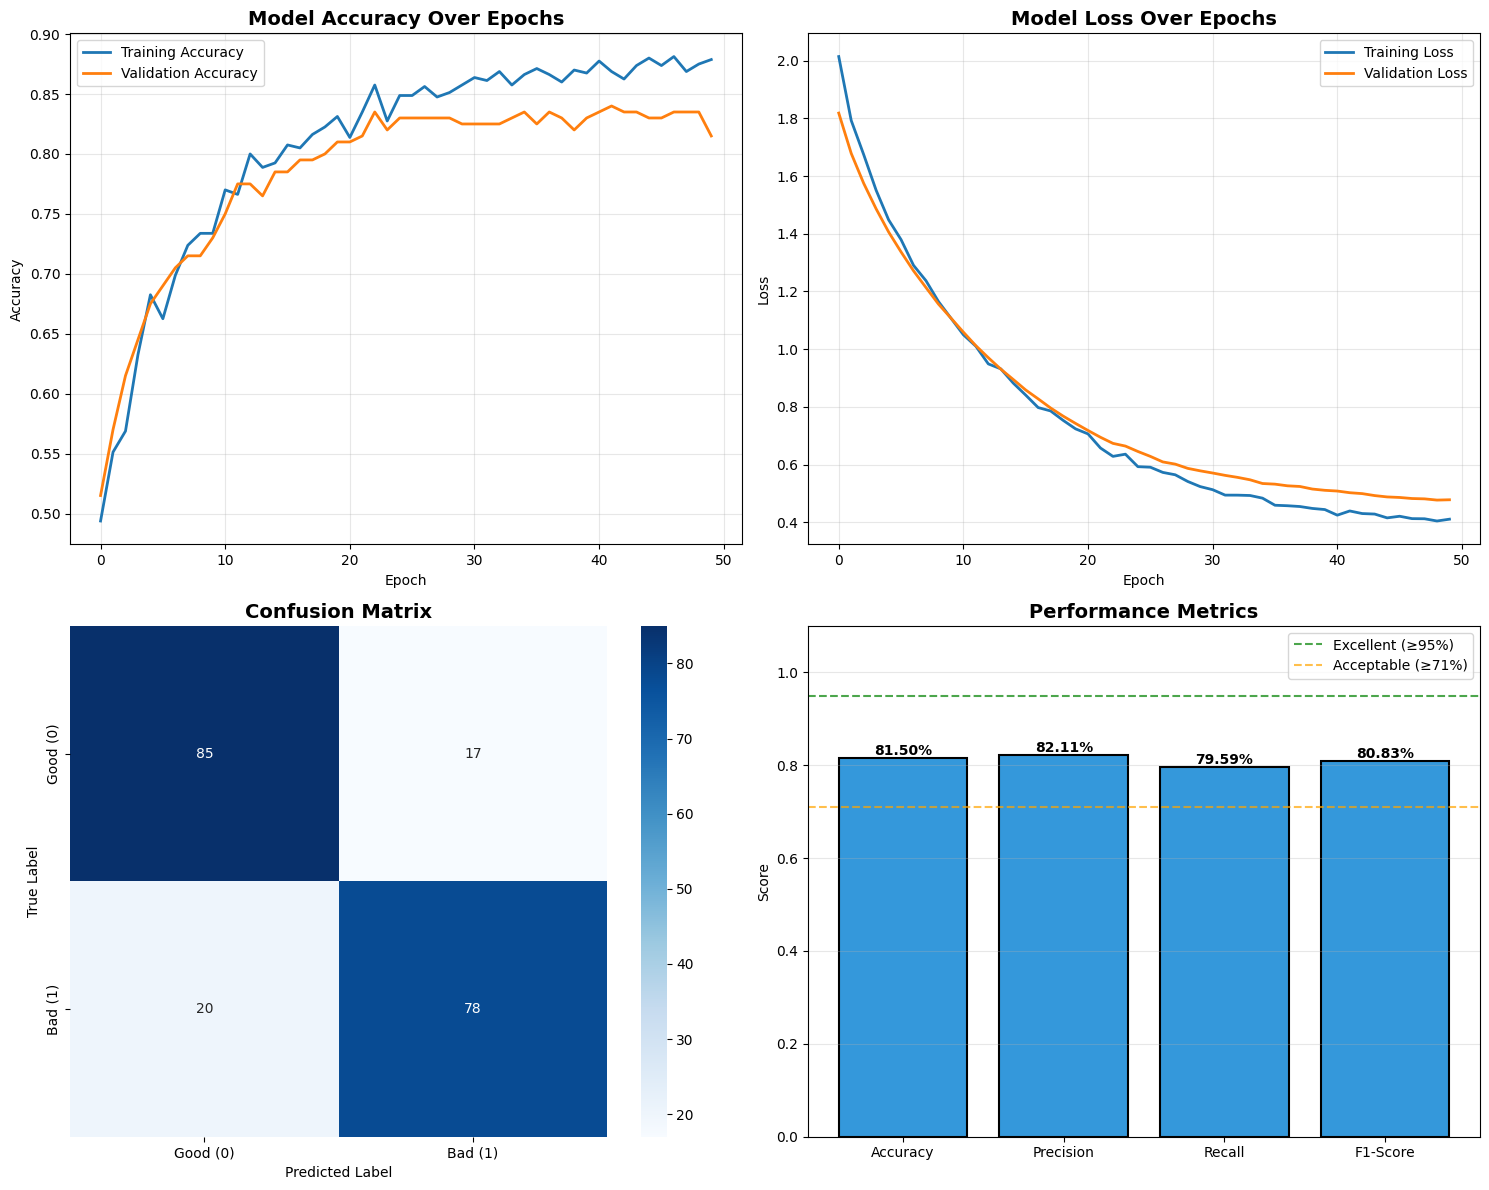

✓ Evaluation plots saved as 'model_evaluation.png'


In [74]:
print("\n[8] GENERATING VISUALIZATIONS...")
print("-"*80)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Training History - Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0, 0].set_title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Training History - Loss
axes[0, 1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[0, 1].set_title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=['Good (0)', 'Bad (1)'],
            yticklabels=['Good (0)', 'Bad (1)'])
axes[1, 0].set_title('Confusion Matrix', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('True Label')
axes[1, 0].set_xlabel('Predicted Label')

# Plot 4: Performance Metrics Bar Chart
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_values = [accuracy, precision, recall, f1]
colors = ['#2ecc71' if v >= 0.95 else '#3498db' if v >= 0.71 else '#e74c3c' 
          for v in metrics_values]
bars = axes[1, 1].bar(metrics_names, metrics_values, color=colors, edgecolor='black', linewidth=1.5)
axes[1, 1].set_title('Performance Metrics', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_ylim([0, 1.1])
axes[1, 1].axhline(y=0.95, color='green', linestyle='--', label='Excellent (≥95%)', alpha=0.7)
axes[1, 1].axhline(y=0.71, color='orange', linestyle='--', label='Acceptable (≥71%)', alpha=0.7)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2%}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('model_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Evaluation plots saved as 'model_evaluation.png'")

Predict sample

In [75]:
print("\n[9] PREDICTION EXAMPLE...")
print("-"*80)

# Take first 5 samples from test set
sample_indices = [0, 1, 2, 3, 4]
sample_data = X_test[sample_indices]
sample_predictions = model.predict(sample_data, verbose=0)
sample_classes = (sample_predictions > 0.5).astype(int).flatten()

print("\nPredictions on sample data:")
print("-"*80)
for i, (pred_prob, pred_class, true_class) in enumerate(zip(sample_predictions, 
                                                            sample_classes, 
                                                            y_test[sample_indices])):
    status = "Good Credit" if pred_class == 0 else "Bad Credit"
    true_status = "Good Credit" if true_class == 0 else "Bad Credit"
    correct = "✓" if pred_class == true_class else "✗"
    print(f"Sample {i+1}: Predicted: {status} ({pred_prob[0]:.2%} probability)")
    print(f"          True Label: {true_status} {correct}")
    print()


[9] PREDICTION EXAMPLE...
--------------------------------------------------------------------------------

Predictions on sample data:
--------------------------------------------------------------------------------
Sample 1: Predicted: Good Credit (48.41% probability)
          True Label: Bad Credit ✗

Sample 2: Predicted: Good Credit (9.64% probability)
          True Label: Good Credit ✓

Sample 3: Predicted: Bad Credit (99.99% probability)
          True Label: Bad Credit ✓

Sample 4: Predicted: Good Credit (44.74% probability)
          True Label: Good Credit ✓

Sample 5: Predicted: Bad Credit (98.78% probability)
          True Label: Bad Credit ✓



Final Summary   

In [76]:
print("\n" + "="*80)
print("✅ REQUIREMENTS CHECKLIST")
print("="*80)
print("✓ Algorithm: Artificial Neural Network (ANN)")
print(f"✓ Dataset: {df.shape[0]} samples (publicly available)")
print("✓ Preprocessing: Data cleaning, encoding, scaling completed")
print("✓ EDA: Exploratory data analysis with visualizations")
print("✓ ANN Architecture:")
print(f"  - Input layer: {X_train.shape[1]} neurons (features)")
print(f"  - Hidden layer 1: 32 neurons with ReLU activation + L2 regularization")
print(f"  - Dropout: 50%")
print(f"  - Hidden layer 2: 16 neurons with ReLU activation + L2 regularization")
print(f"  - Dropout: 30%")
print(f"  - Output layer: 1 neuron with Sigmoid activation")
print("  - Optimizer: Adam (learning_rate=0.0005)")
print("  - Loss: Binary Crossentropy")
print("✓ Evaluation Metrics:")
print(f"  - Accuracy: {accuracy*100:.2f}%")
print(f"  - Precision: {precision*100:.2f}%")
print(f"  - Recall: {recall*100:.2f}%")
print(f"  - F1-Score: {f1*100:.2f}%")
print("  - Confusion Matrix: Generated")
print("\n" + "="*80)
print("🎓 PROJECT COMPLETE! ALL REQUIREMENTS MET!")
print("="*80)


✅ REQUIREMENTS CHECKLIST
✓ Algorithm: Artificial Neural Network (ANN)
✓ Dataset: 1000 samples (publicly available)
✓ Preprocessing: Data cleaning, encoding, scaling completed
✓ EDA: Exploratory data analysis with visualizations
✓ ANN Architecture:
  - Input layer: 46 neurons (features)
  - Hidden layer 1: 32 neurons with ReLU activation + L2 regularization
  - Dropout: 50%
  - Hidden layer 2: 16 neurons with ReLU activation + L2 regularization
  - Dropout: 30%
  - Output layer: 1 neuron with Sigmoid activation
  - Optimizer: Adam (learning_rate=0.0005)
  - Loss: Binary Crossentropy
✓ Evaluation Metrics:
  - Accuracy: 81.50%
  - Precision: 82.11%
  - Recall: 79.59%
  - F1-Score: 80.83%
  - Confusion Matrix: Generated

🎓 PROJECT COMPLETE! ALL REQUIREMENTS MET!
